In [57]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import datetime
from time import time

In [7]:
# custom_date_parser = lambda x: datetime.strptime(x, "%Y-%d-%m %H:%M:%S")
custom_date_parser = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d")

In [8]:
data = pd.read_csv("C:/Users/User/Desktop/Mayada Kh/Scripts - all/TIme series/ice_cream.csv",
                  parse_dates = [0], index_col = 0, date_parser = custom_date_parser )

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 577 entries, 1972-01-01 to 2020-01-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  577 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [10]:
data.rename(columns = {'IPN31152N': 'Production'}, inplace = True)

In [11]:
data.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [34]:
#infer the frequency of the data 
data = data.asfreq(pd.infer_freq(data.index))

In [35]:
#subset data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
data = data[start_date:]

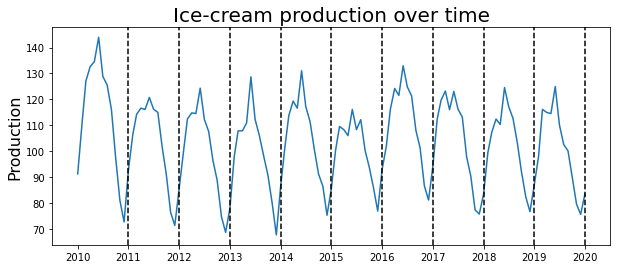

In [40]:
plt.figure(figsize = (10,4))
plt.plot(data.Production)
plt.title('Ice-cream production over time', fontsize = 20)
plt.ylabel('Production', fontsize = 16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color ='k', linestyle = '--',)

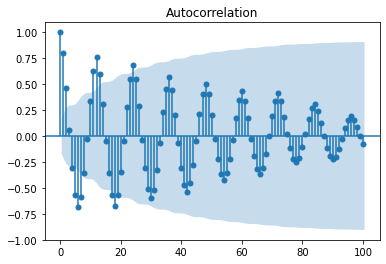

In [42]:
acf_plot = plot_acf(data.Production, lags = 100)

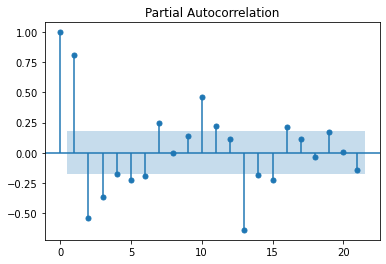

In [43]:
pacf_plot = plot_pacf(data.Production)

### Split the data into train and test sets


In [45]:
train_end = pd.Timestamp('2018-12-01')
test_end = pd.Timestamp('2019-12-01')
train_data = data[:train_end]
test_data = data[train_end + timedelta(days =1):test_end]

### Fitting the model

In [59]:
model = ARIMA(train_data, order = (3,0,0)) # order = (AR, I, MA)
#starting with lag 3 model

In [60]:
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time:', end - start)

Model fitting time: 0.5259323120117188


In [61]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Tue, 05 Apr 2022   AIC                            758.170
Time:                        11:49:06   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.765      -0.396       0.291
ar.L3         -0.4044      0.123     -3.290      0.001      -0.645      -0.164
sigma2        58.4026      9.475      6.164      0.000      39.831      76.974
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 8.71
Prob(Q):                              0.43   Prob(JB):                         0.01
Heteroskedasticity (H):               0.76   Skew:                             0.70
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make predictions

In [74]:
pred_start_date = test_data.index[0]
pred_end_data = test_data.index[-1]

In [75]:
predictions = model_fit.predict(start =pred_start_date, end =pred_end_data )
residuals = test_data.Production - predictions

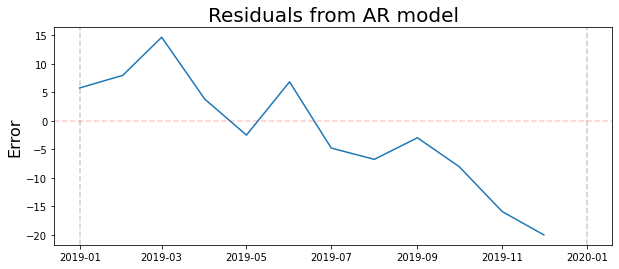

In [76]:
plt.figure(figsize = (10,4))
plt.plot(residuals)
plt.title('Residuals from AR model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color ='k', linestyle = '--', alpha = 0.2)

Residuals are decreasin over time which means there is something in the dynamics of the data that we did not capture with this model

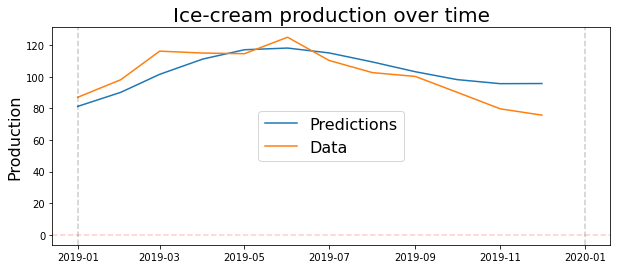

In [81]:
plt.figure(figsize = (10,4))
plt.plot(predictions)
plt.plot(test_data.Production)
plt.legend(('Predictions', 'Data'), fontsize = 16)
plt.title('Ice-cream production over time', fontsize = 20)
plt.ylabel('Production', fontsize = 16)
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color ='k', linestyle = '--', alpha = 0.2)

In [85]:
print('Mean absolute percent error:', round(np.mean(abs(residuals/test_data.Production)), 4))
print('Root mean square error:', np.sqrt(np.mean(residuals**2)))

Mean absolute percent error: 0.0895
Root mean square error: 9.884158749946456


### Rolling Forecast origin 

* **Idea:** Predict one month in advance each time.
* **Why?** -> It is known that when we aim to predict values further than our training data the model's performance decreases. That is, if we have a period of 10 year and we train on 7 and test on 3, the model will mostly fail to predict the the feature properly as we go further into those 3 years 
* **Explained:**
    * train on months 1,2,....,k-3 &#8594; predict month k-2
    * train on months 1,2,....,k-3, k-2 &#8594; predict month k-1
    * train on months 1,2,....,k-3, k-2, k-1 &#8594; predict month k

In [86]:
train_end = pd.Timestamp('2016-12-01')
test_end = pd.Timestamp('2019-12-01')
train_data = data[:train_end]
test_data = data[train_end + timedelta(days =1):test_end]

In [96]:
predictions_rolling = pd.Series(dtype='float64')
for end_date in test_data.index:
    training_data = data[:end_date - timedelta(days=1)]
    model = ARIMA(training_data, order = (3,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]

In [97]:
residuals = test_data.Production - predictions_rolling

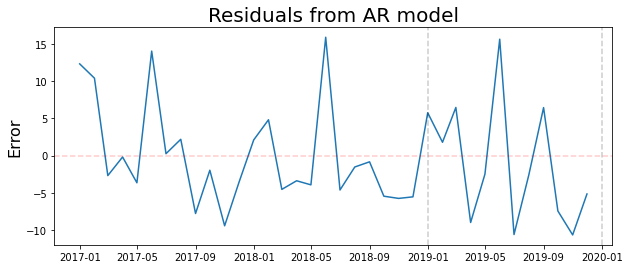

In [98]:
plt.figure(figsize = (10,4))
plt.plot(residuals)
plt.title('Residuals from AR model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color ='k', linestyle = '--', alpha = 0.2)

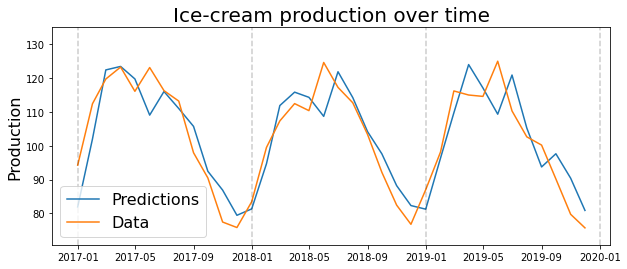

In [107]:
plt.figure(figsize = (10,4))
plt.plot(predictions_rolling)
plt.plot(test_data.Production)
plt.legend(('Predictions', 'Data'), fontsize = 16)
plt.title('Ice-cream production over time', fontsize = 20)
plt.ylabel('Production', fontsize = 16)
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.2)
plt.ylim([test_data.Production.min() - 5, test_data.Production.max() + 10])
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color ='k', linestyle = '--', alpha = 0.2)